In [1]:
from utils.helper import  *
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
f_dir = 'diagnostic_data/class_test/'
# read all trials
n_trials = 2
n_iter = 20
objs=['stiff_block', 'carton_box', 'soft_block', 'sponge']
all_trials = list()
all_trials_rbtq = list()

for i in range(2,n_trials+1):
    for j in range(1,n_iter+1):
        for obj in objs:
            if (i == 1) & (j == 20):
                continue
                
            fname = f_dir + f"{obj}_trial{i}_{j}"
            temp_df_rbtq, start_time = read_robotiq(fname+'.rbtq')
            
            temp_df_rbtq = temp_df_rbtq.assign(iteration = j)
            temp_df_rbtq = temp_df_rbtq.assign(obj = obj)
            all_trials_rbtq.append(temp_df_rbtq)
            
            temp_df = read_tac_file2(fname+'.tact', start_time)
            #print(temp_df_rbtq.time[0], temp_df.time[0])
            temp_df = temp_df[temp_df.taxel != 0]
            temp_df = temp_df.assign(iteration = j)
            temp_df = temp_df.assign(obj = obj)
            all_trials.append(temp_df)

In [3]:
#start_time

In [4]:
df_rbtq = pd.concat(all_trials_rbtq)
df = pd.concat(all_trials)
def map_to_finger(taxel_id):
    if (taxel_id <= 39) & (taxel_id >=1):
        return 'left_finger'
    else :
        return 'right_finger'

df = df.assign(finger_type = df.taxel.apply(map_to_finger))

In [5]:
df_rbtq.head()

,time,target,current,iteration,obj
0,0.000000,0,3,1,stiff_block
1,0.011966,255,3,1,stiff_block
2,0.023995,255,3,1,stiff_block
3,0.031414,255,4,1,stiff_block
4,0.039947,255,4,1,stiff_block


In [6]:
df.head()

,isNeg,taxel,time,iteration,obj,finger_type
0,0,52,2.708209,1,stiff_block,right_finger
1,0,54,2.708237,1,stiff_block,right_finger
2,0,57,2.708253,1,stiff_block,right_finger
3,0,52,2.708266,1,stiff_block,right_finger
4,0,54,2.708280,1,stiff_block,right_finger


### Spike Counts
1. Total
2. By polarity
3. By obj

In [7]:
count_df = df.groupby(['obj', 'isNeg', 'iteration']).count().reset_index()

In [8]:
count_df

,obj,isNeg,iteration,taxel,time,finger_type
0,carton_box,0,1,3071,3071,3071
1,carton_box,0,2,3526,3526,3526
2,carton_box,0,3,3097,3097,3097
3,carton_box,0,4,2973,2973,2973
4,carton_box,0,5,2943,2943,2943
...,...,...,...,...,...,...
155,stiff_block,1,16,1820,1820,1820
156,stiff_block,1,17,1716,1716,1716
157,stiff_block,1,18,1765,1765,1765
158,stiff_block,1,19,1557,1557,1557


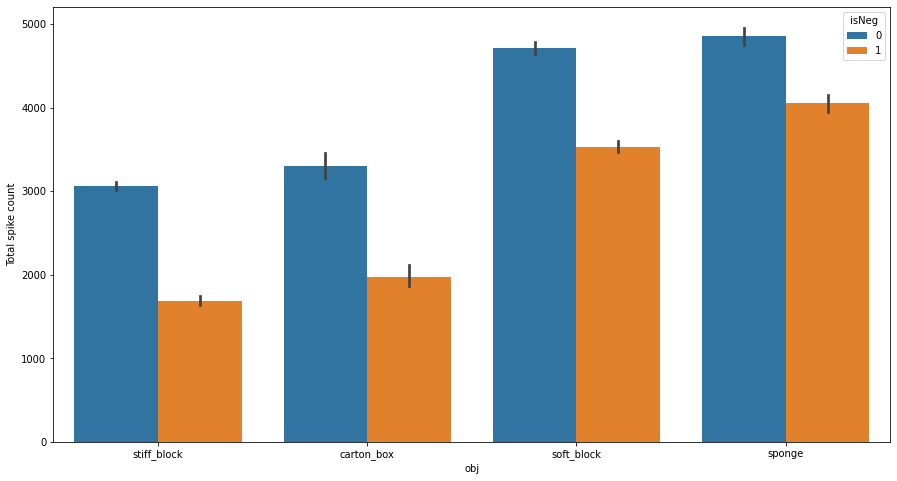

In [9]:
fig, ax = plt.subplots(figsize=(15,8))
sns.barplot(ax=ax, x = 'obj', y='time', hue='isNeg', order=objs, data=count_df)
#ax.set_ylim([3500,6500])
ax.set_ylabel('Total spike count')
plt.show()

In [10]:
### See spikes over time
t_range = np.linspace(0, 4.4, 220)
df_bin_range = pd.cut(df.time, t_range)
groups = df.groupby(['iteration', 'finger_type','obj', df_bin_range]).count()
count_df = groups.add_suffix('_count').reset_index()
def map_to_cat(x):
    return np.float(x.right)
count_df = count_df.assign(time_int = count_df.time.apply(map_to_cat).astype(np.float))

In [11]:
count_df.head()

,iteration,finger_type,obj,time,isNeg_count,taxel_count,time_count,time_int
0,1,left_finger,carton_box,"(0.0, 0.0201]",NaN,NaN,NaN,0.0201
1,1,left_finger,carton_box,"(0.0201, 0.0402]",NaN,NaN,NaN,0.0402
2,1,left_finger,carton_box,"(0.0402, 0.0603]",NaN,NaN,NaN,0.0603
3,1,left_finger,carton_box,"(0.0603, 0.0804]",NaN,NaN,NaN,0.0804
4,1,left_finger,carton_box,"(0.0804, 0.1]",NaN,NaN,NaN,0.1000


In [12]:
count_df.taxel_count = count_df.taxel_count.fillna(0)

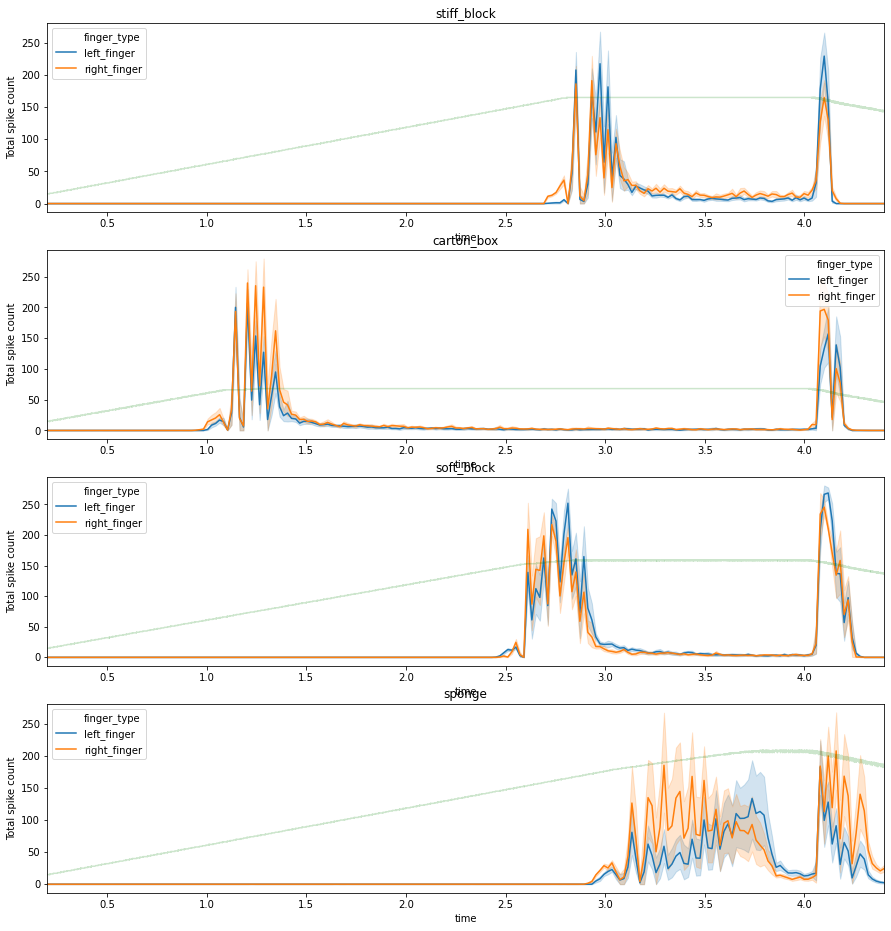

In [13]:
fig, ax = plt.subplots(len(objs),figsize=(15,4*len(objs)))
for i in range(len(objs)):
    sns.lineplot(ax=ax[i], x = 'time_int', y='taxel_count', hue='finger_type', data=count_df[count_df.obj == objs[i]])
    #ax.set_ylim([3500,6500])
    ax[i].set_title(objs[i])
    sns.lineplot(ax=ax[i], x = 'time', y='current', data=df_rbtq[df_rbtq.obj == objs[i]], alpha=0.2, color='g')
    ax[i].set_ylabel('Total spike count')
    ax[i].set_xlim([0.2, 4.4])
plt.savefig('4_objs_trial2.png', dpi=1000)
plt.show()

### Stiff block left
![log](diagnostic_data/taxel_imgs/stiff_block_left_finger_1.png)
### Stiff block right
![log](diagnostic_data/taxel_imgs/stiff_block_right_finger_2.png)

### Soft block left
![log](diagnostic_data/taxel_imgs/soft_block_left_finger_1.png)
### Soft block right
![log](diagnostic_data/taxel_imgs/soft_block_right_finger_1.png)

### Sponge left
![log](diagnostic_data/taxel_imgs/sponge_left_finger_1.png)
### Sponge right
![log](diagnostic_data/taxel_imgs/sponge_right_finger_1.png)